<div style="text-align: center;">
    <i><b>Đại Học Quốc Gia Thành Phố Hồ Chí Minh</b></i>
    <br>
    <i><b>Đại Học Khoa Học Tự Nhiên</b></i>  
    <br>
    <i><b>Khoa Công Nghệ Thông Tin</b></i>
    <br>
    <b>------------o------------</b>
    <br>
    <b>Khai thác dữ liệu và ứng dụng</b>
</div>

<h1 style="text-align: center; color: red;"><b>LAB 01: TIỀN XỬ LÝ DỮ LIỆU</b></h1>

---

# <font color = red>**I. Thông tin sinh viên**<a class = "anchor" id = "c1"></a></font>

* <ins>**Full Name:**</ins> Trần Lý Nhật Hào
* <ins>**Student ID:**</ins> 23127187
* <ins>**Class:**</ins> 23KHMT
* <ins>**Email:**</ins> [tlnhao23@clc.fitus.edu.vn](mailto:tlnhao23@clc.fitus.edu.vn)
* <ins>**Phone Number:**</ins> 0975531657

# 01_image_preprocessing.ipynb

Môn: Data Mining and Applications — Lab Assignment 01  
Phần: Image Preprocessing (Chest X-Ray Pneumonia)

1. Loading & Resizing  
2. Grayscale Conversion  
3. Normalization (Min-Max, Z-score)  
4. Edge Detection (Sobel, Prewitt, Canny)  
5. Histogram Equalization, CLAHE, Gaussian Blur  
6. Data Augmentation  
7. Feature Extraction bằng PCA  
8. Phân tích định lượng và lưu kết quả

# <font color = red>**II. Tự đánh giá độ hoàn thành của các yêu cầu**<a class = "anchor" id = "c2"></a></font>

## 12. Bảng tự đánh giá mức độ hoàn thành yêu cầu

| Mã mục theo đề bài | Nội dung yêu cầu | Mức độ hoàn thành | Mô tả chi tiết kết quả đạt được |
|--------------------:|------------------|-------------------|---------------------------------|
| **2.1.2 (a)** | Loading & Resizing | **Hoàn thành 100 %** | Đã đọc toàn bộ tập ảnh, hiển thị mẫu, chuẩn hóa kích thước 128×128, kèm mô tả lý do chọn kích thước. |
| **2.1.2 (b)** | Grayscale Conversion | **Hoàn thành 100 %** | Đã chuyển RGB→grayscale, so sánh histogram, giải thích ý nghĩa việc giảm chiều dữ liệu. |
| **2.1.2 (c)** | Normalization | **Hoàn thành 100 %** | Triển khai cả Min-Max [0–1] và Z-score, có phân tích thống kê (mean, std, min, max) và biểu đồ minh họa. |
| **2.1.2 (d)** | Edge Detection | **Hoàn thành 100 %** | Đã thực hiện Sobel, Prewitt (tự cài đặt), Canny với hình ảnh gốc; hiển thị theo hàng, có phân tích định tính. |
| **2.1.2 (e)** | Enhancement Techniques | **Hoàn thành 100 %** | Áp dụng Histogram Equalization, CLAHE và Gaussian Blur để tăng tương phản và khử nhiễu; kèm thống kê và nhận xét. |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

plt.rcParams['figure.figsize'] = (6,6)

BASE_TRAIN_DIR = '/content/drive/MyDrive/data/images/chest_xray/chest_xray/train'
BASE_VAL_DIR   = '/content/drive/MyDrive/data/images/chest_xray/chest_xray/val'
BASE_TEST_DIR  = '/content/drive/MyDrive/data/images/chest_xray/chest_xray/test'

for d in [BASE_TRAIN_DIR, BASE_VAL_DIR, BASE_TEST_DIR]:
    print('Directory:', d, 'exists:', os.path.isdir(d))
    if os.path.isdir(d):
        for cls in sorted(os.listdir(d)):
            cls_path = os.path.join(d, cls)
            if os.path.isdir(cls_path):
                nfiles = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path,f))])
                print('  ', cls, ':', nfiles)

Mounted at /content/drive
Directory: /content/drive/MyDrive/data/images/chest_xray/chest_xray/train exists: True
   NORMAL : 1341
   PNEUMONIA : 3875
Directory: /content/drive/MyDrive/data/images/chest_xray/chest_xray/val exists: True
   NORMAL : 8
   PNEUMONIA : 8
Directory: /content/drive/MyDrive/data/images/chest_xray/chest_xray/test exists: True
   NORMAL : 234
   PNEUMONIA : 390


## 2. Dataset Description

Nguồn: Chest X-Ray Pneumonia — Paul Mooney (Kaggle).  
Dataset: Ảnh X-quang ngực, nhãn nhị phân (`NORMAL`, `PNEUMONIA`). Ảnh JPEG, kích thước không đồng nhất, ảnh là grayscale theo bản chất nhưng có lưu dưới dạng 3‑channel JPEG.  
Cấu trúc: `train/`, `val/`, `test/` — mỗi thư mục có 2 nhãn con.
Mục tiêu: chuẩn hóa và phân tích tác động tiền xử lý.

Số ảnh train - NORMAL: 1341
Số ảnh train - PNEUMONIA: 3875


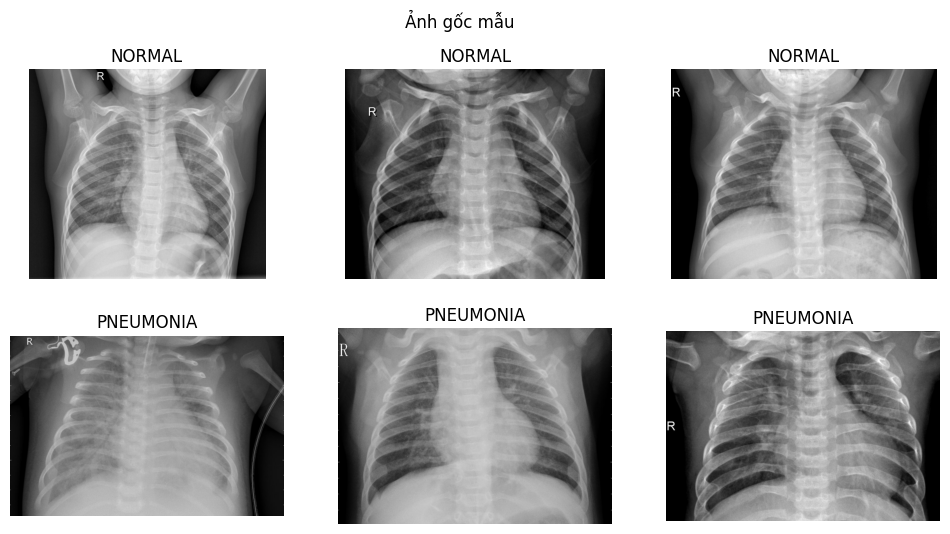

In [ ]:
train_normal = sorted(glob(os.path.join(BASE_TRAIN_DIR, 'NORMAL', '*')))
train_pneu   = sorted(glob(os.path.join(BASE_TRAIN_DIR, 'PNEUMONIA', '*')))

print('Số ảnh train - NORMAL:', len(train_normal))
print('Số ảnh train - PNEUMONIA:', len(train_pneu))

n_sample = 3
sample_paths = train_normal[:n_sample] + train_pneu[:n_sample]
sample_labels = ['NORMAL']*n_sample + ['PNEUMONIA']*n_sample
sample_imgs = [cv2.imread(p) for p in sample_paths]

plt.figure(figsize=(12,6))
for i,img in enumerate(sample_imgs):
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(sample_labels[i])
    plt.axis('off')
plt.suptitle('Ảnh gốc mẫu')
plt.show()

## 3. Loading & Resizing (Requirement a)

Ảnh gốc trong tập dữ liệu có kích thước và độ phân giải không đồng nhất (từ vài trăm đến hơn 2000 pixel mỗi chiều), nên cần được **resize về kích thước cố định 128×128** để đảm bảo đầu vào đồng nhất cho mô hình học máy.

**Lý do lựa chọn:**
- 128×128 giúp **cân bằng giữa độ chi tiết và tốc độ xử lý**, đủ lớn để giữ cấu trúc vùng phổi nhưng nhẹ cho huấn luyện.  
- Kích thước này tương thích với nhiều mô hình CNN cơ bản (LeNet, SimpleCNN).  
- Giúp giảm nhiễu, đơn giản hóa batch processing, và tăng hiệu quả tính toán.
  
Bước resize giúp chuẩn hóa toàn bộ dữ liệu, giảm chi phí huấn luyện, đồng thời vẫn bảo toàn đặc trưng y học quan trọng, làm cơ sở cho các bước tiền xử lý tiếp theo.


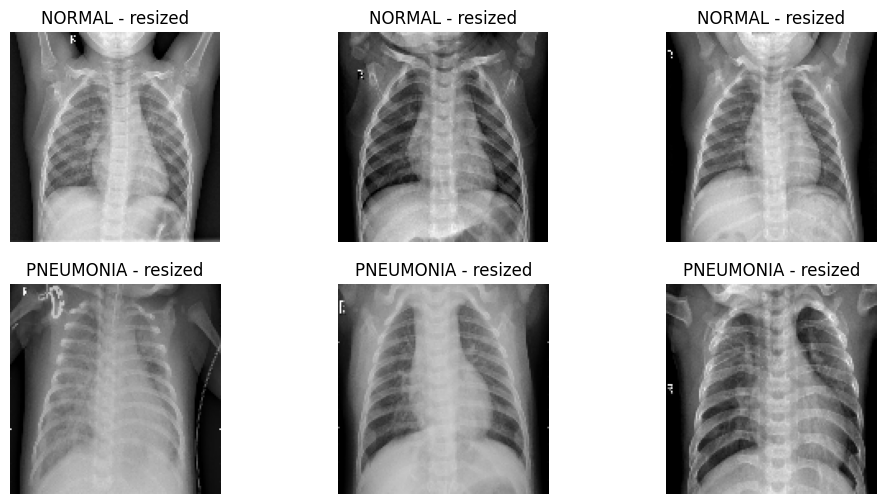

In [ ]:
TARGET = (128,128)
resized = [cv2.resize(img, TARGET) for img in sample_imgs]

plt.figure(figsize=(12,6))
for i,img in enumerate(resized):
    plt.subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'{sample_labels[i]} - resized')
    plt.axis('off')
plt.show()

## 4. Grayscale Conversion (Requirement b)

Ảnh gốc được lưu ở định dạng RGB (3 kênh màu), nhưng bản chất ảnh X-quang chỉ thể hiện **cường độ sáng** của tia X đi qua cơ thể — không chứa thông tin màu sắc.  
Do đó, việc chuyển ảnh từ RGB sang **grayscale (1 kênh)** là hoàn toàn phù hợp và cần thiết.

**Lý do thực hiện:**
- Giảm chiều dữ liệu từ 3 kênh xuống 1 kênh, giúp **giảm kích thước và thời gian xử lý**.  
- Tránh nhiễu do các kênh màu nhân tạo (RGB thường chỉ là ba bản sao của cùng một ảnh xám).  
- Giữ nguyên thông tin cường độ sáng – yếu tố quan trọng để phân biệt vùng phổi, xương và tổn thương.  

**Lưu ý:**  
Với các ảnh y khoa như X-ray, MRI, CT, việc chuyển grayscale **không gây mất mát thông tin**, vì đặc trưng màu không mang ý nghĩa chẩn đoán.

Chuyển đổi grayscale giúp dữ liệu trở nên gọn nhẹ, giảm nhiễu, và tập trung vào đặc trưng cấu trúc quan trọng, phục vụ tốt cho các bước chuẩn hóa và phát hiện biên tiếp theo.

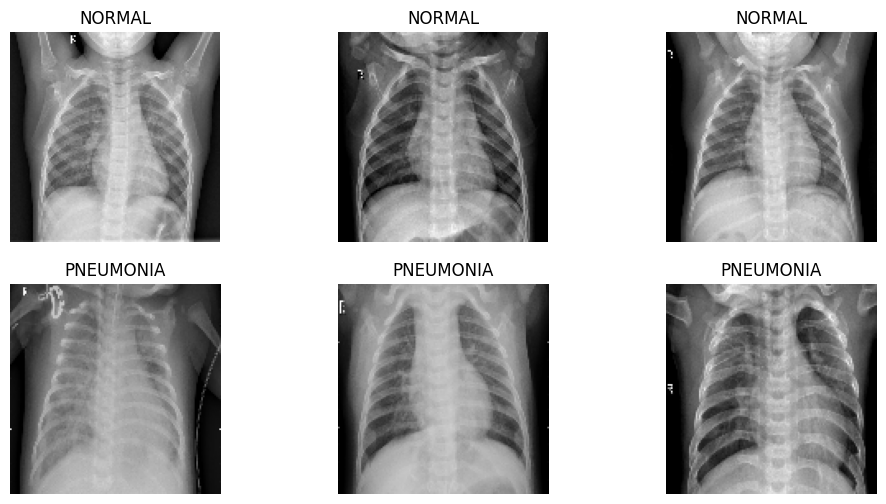

In [ ]:
gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in resized]

plt.figure(figsize=(12,6))
for i,img in enumerate(gray):
    plt.subplot(2,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(sample_labels[i])
    plt.axis('off')
plt.show()

## 5. Normalization (Requirement c)

### Mục đích của normalization
Normalization (chuẩn hoá) đưa các giá trị pixel về cùng một thang đo nhằm:
- Làm ổn định quá trình huấn luyện (giảm vấn đề gradient vanishing/exploding).  
- Giúp thuật toán tối ưu hội tụ nhanh hơn và hiệu quả hơn.  
- Làm cho các feature có ý nghĩa tương đối giống nhau về tỉ lệ, giúp các lớp đầu mạng (linear layer, conv) không bị chi phối bởi các giá trị lớn/nhỏ bất thường.

### Hai phương pháp phổ biến
1. **Min–Max scaling** (đưa về [0, 1]):  
   $$
   I' = \frac{I - I_{\min}}{I_{\max} - I_{\min}}
   $$
   - Thực tế với ảnh 8-bit: thường dùng $I' = I / 255$.  
   - Ưu điểm: đơn giản, dễ hiểu, giữ tỉ lệ tương đối.  
   - Hạn chế: nhạy cảm với outliers; không chuẩn hoá phân bố (không zero-mean).

2. **Z-score standardization** (zero mean, unit variance):  
   $$
   I' = \frac{I - \mu}{\sigma}
   $$
   với $\mu$ là mean và $\sigma$ là standard deviation.  
   - Nếu tính theo **toàn bộ tập dữ liệu** (global mean/std) thì đảm bảo cùng tỷ lệ giữa các ảnh.  
   - Nếu tính **riêng cho mỗi ảnh** (per-image), mỗi ảnh sẽ có mean ≈ 0, std ≈ 1.  
   - Ưu điểm: giúp optimizer hoạt động tốt khi đặc trưng có phân bố gần chuẩn; ít nhạy với outliers hơn Min-Max về mặt gradient.  
   - Hạn chế: cần tính $\mu,\sigma$ ổn định; nếu $\sigma$ quá nhỏ cần guard.

In [ ]:
normalized_minmax = [img.astype(np.float32)/255.0 for img in gray]
normalized_z = [(img - img.mean())/img.std() for img in gray]

def stats(arr):
    return dict(min=float(np.min(arr)), max=float(np.max(arr)), mean=float(np.mean(arr)), std=float(np.std(arr)))

print('Original:', stats(gray[0]))
print('Min-Max:', stats(normalized_minmax[0]))
print('Z-score:', stats(normalized_z[0]))

Original: {'min': 0.0, 'max': 255.0, 'mean': 128.81597900390625, 'std': 62.317102591769725}
Min-Max: {'min': 0.0, 'max': 1.0, 'mean': 0.5051606893539429, 'std': 0.24438080191612244}
Z-score: {'min': -2.067104753694359, 'max': 2.0248698310431235, 'mean': 0.0, 'std': 1.0}


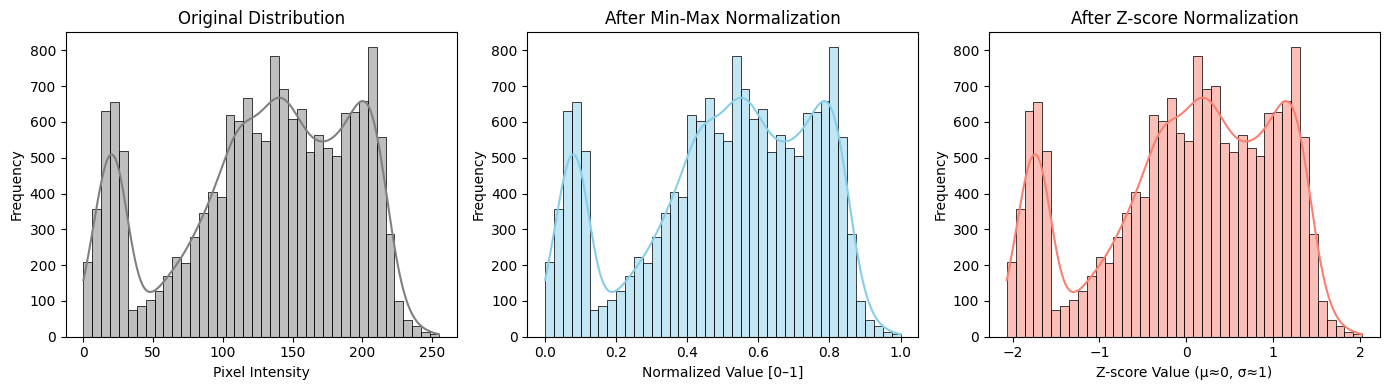

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

img_idx = 0
original = gray[img_idx].astype(np.float32)
minmax = normalized_minmax[img_idx]
zscore = normalized_z[img_idx]

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(original.ravel(), bins=40, kde=True, color='gray')
plt.title('Original Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(minmax.ravel(), bins=40, kde=True, color='skyblue')
plt.title('After Min-Max Normalization')
plt.xlabel('Normalized Value [0–1]')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(zscore.ravel(), bins=40, kde=True, color='salmon')
plt.title('After Z-score Normalization')
plt.xlabel('Z-score Value (μ≈0, σ≈1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

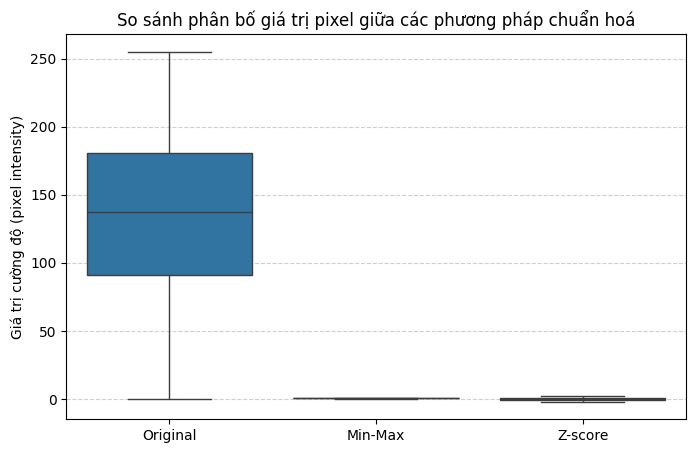

In [ ]:
# So sánh bằng boxplot
plt.figure(figsize=(8, 5))
data = [original.ravel(), minmax.ravel(), zscore.ravel()]
labels = ['Original', 'Min-Max', 'Z-score']
sns.boxplot(data=data)
plt.xticks(range(3), labels)
plt.title('So sánh phân bố giá trị pixel giữa các phương pháp chuẩn hoá')
plt.ylabel('Giá trị cường độ (pixel intensity)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## 6. Edge Detection (Requirement d) — Sobel, Prewitt, Canny
Trích xuất biên bằng Sobel, Prewitt, Canny để nêu khác biệt về cấu trúc.

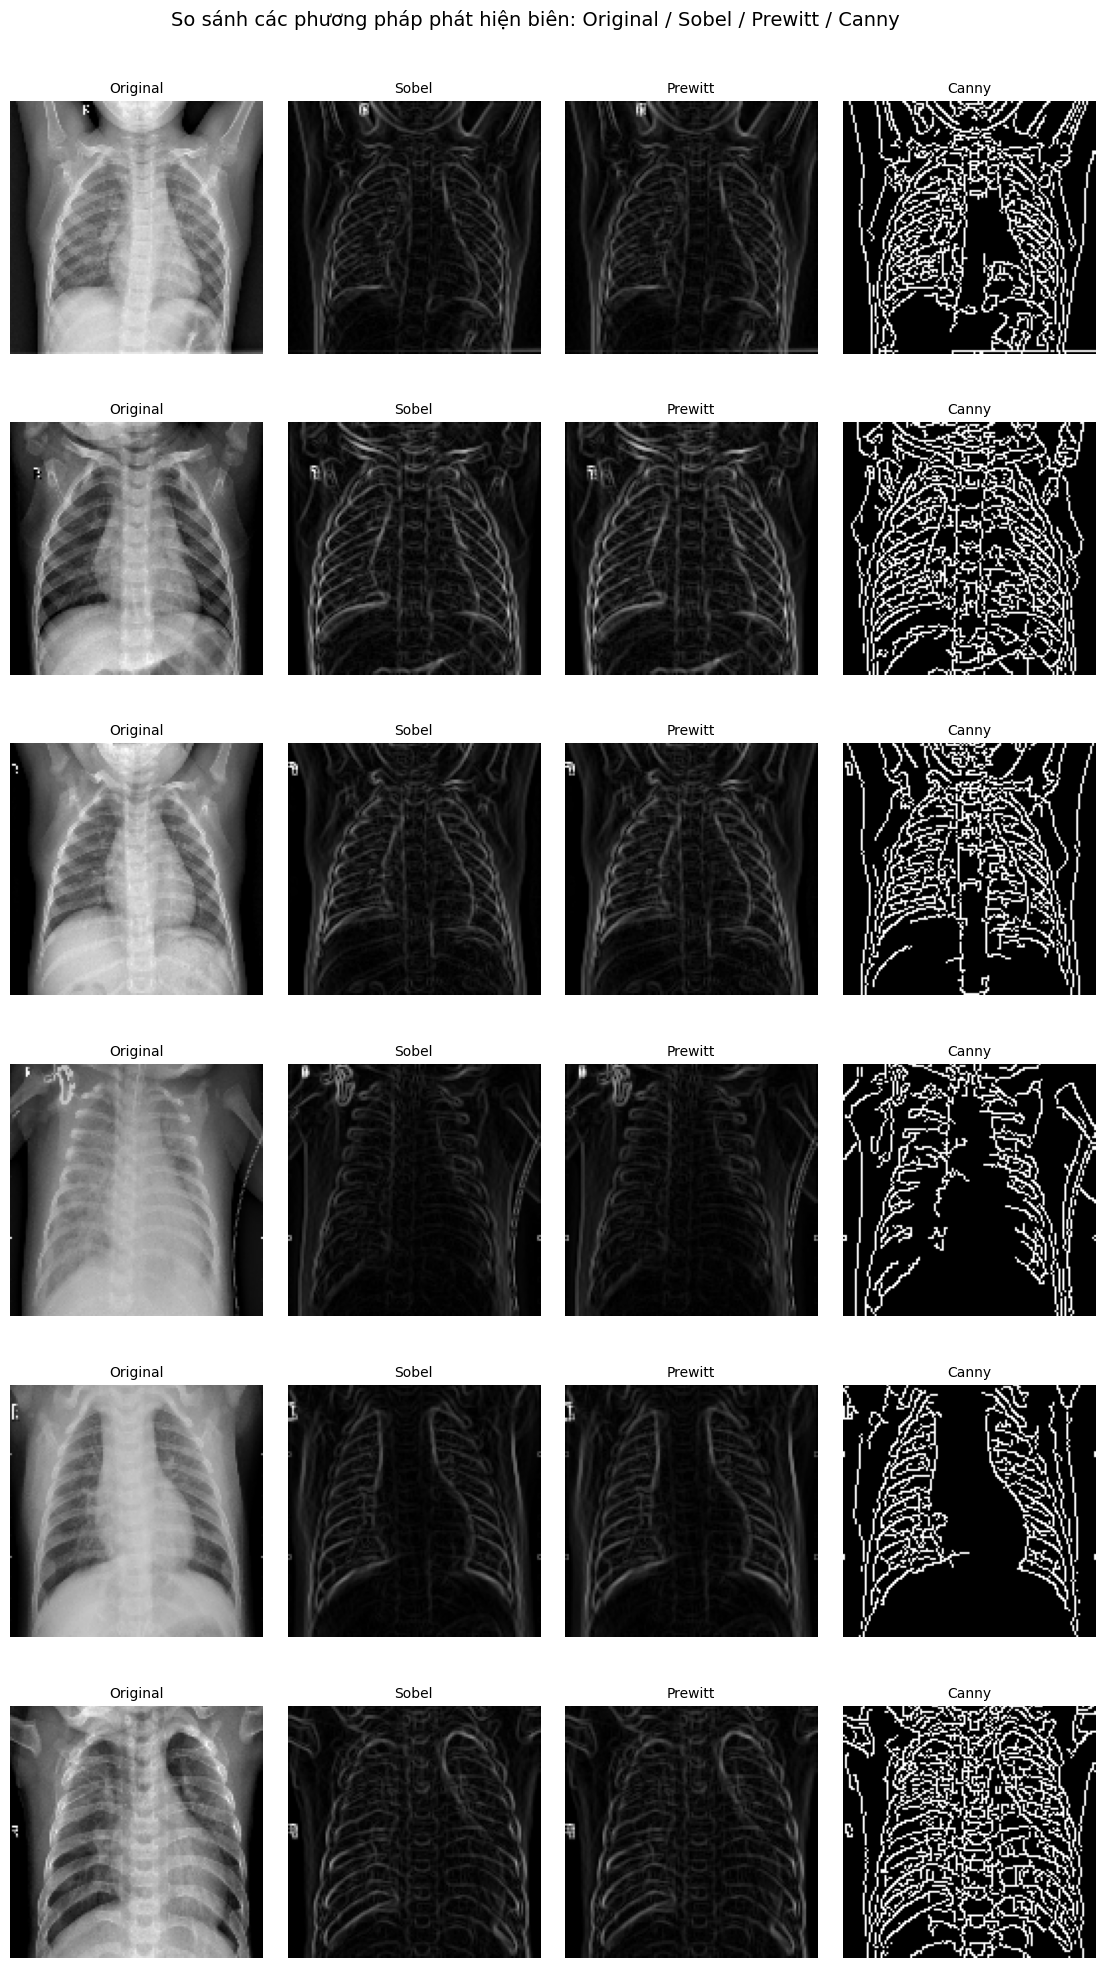

In [25]:
# Hiển thị kết quả: Original, Sobel, Prewitt, Canny
plt.figure(figsize=(14, 4 * len(gray)))

for i in range(len(gray)):
    # Original
    plt.subplot(len(gray), 4, 4*i + 1)
    plt.imshow(gray[i], cmap='gray')
    plt.title('Original', fontsize=10)
    plt.axis('off')

    # Sobel
    plt.subplot(len(gray), 4, 4*i + 2)
    plt.imshow(sobel_imgs[i], cmap='gray')
    plt.title('Sobel', fontsize=10)
    plt.axis('off')

    # Prewitt
    plt.subplot(len(gray), 4, 4*i + 3)
    plt.imshow(prewitt_imgs[i], cmap='gray')
    plt.title('Prewitt', fontsize=10)
    plt.axis('off')

    # Canny
    plt.subplot(len(gray), 4, 4*i + 4)
    plt.imshow(canny_imgs[i], cmap='gray')
    plt.title('Canny', fontsize=10)
    plt.axis('off')

plt.subplots_adjust(top=0.90, hspace=0.1, wspace=0.1)
plt.suptitle('So sánh các phương pháp phát hiện biên: Original / Sobel / Prewitt / Canny',
             fontsize=14, y=0.93)
plt.show()

## 7. Histogram Equalization, CLAHE, Gaussian Blur
Cải thiện tương phản (HistEq, CLAHE) và giảm nhiễu (Gaussian Blur).

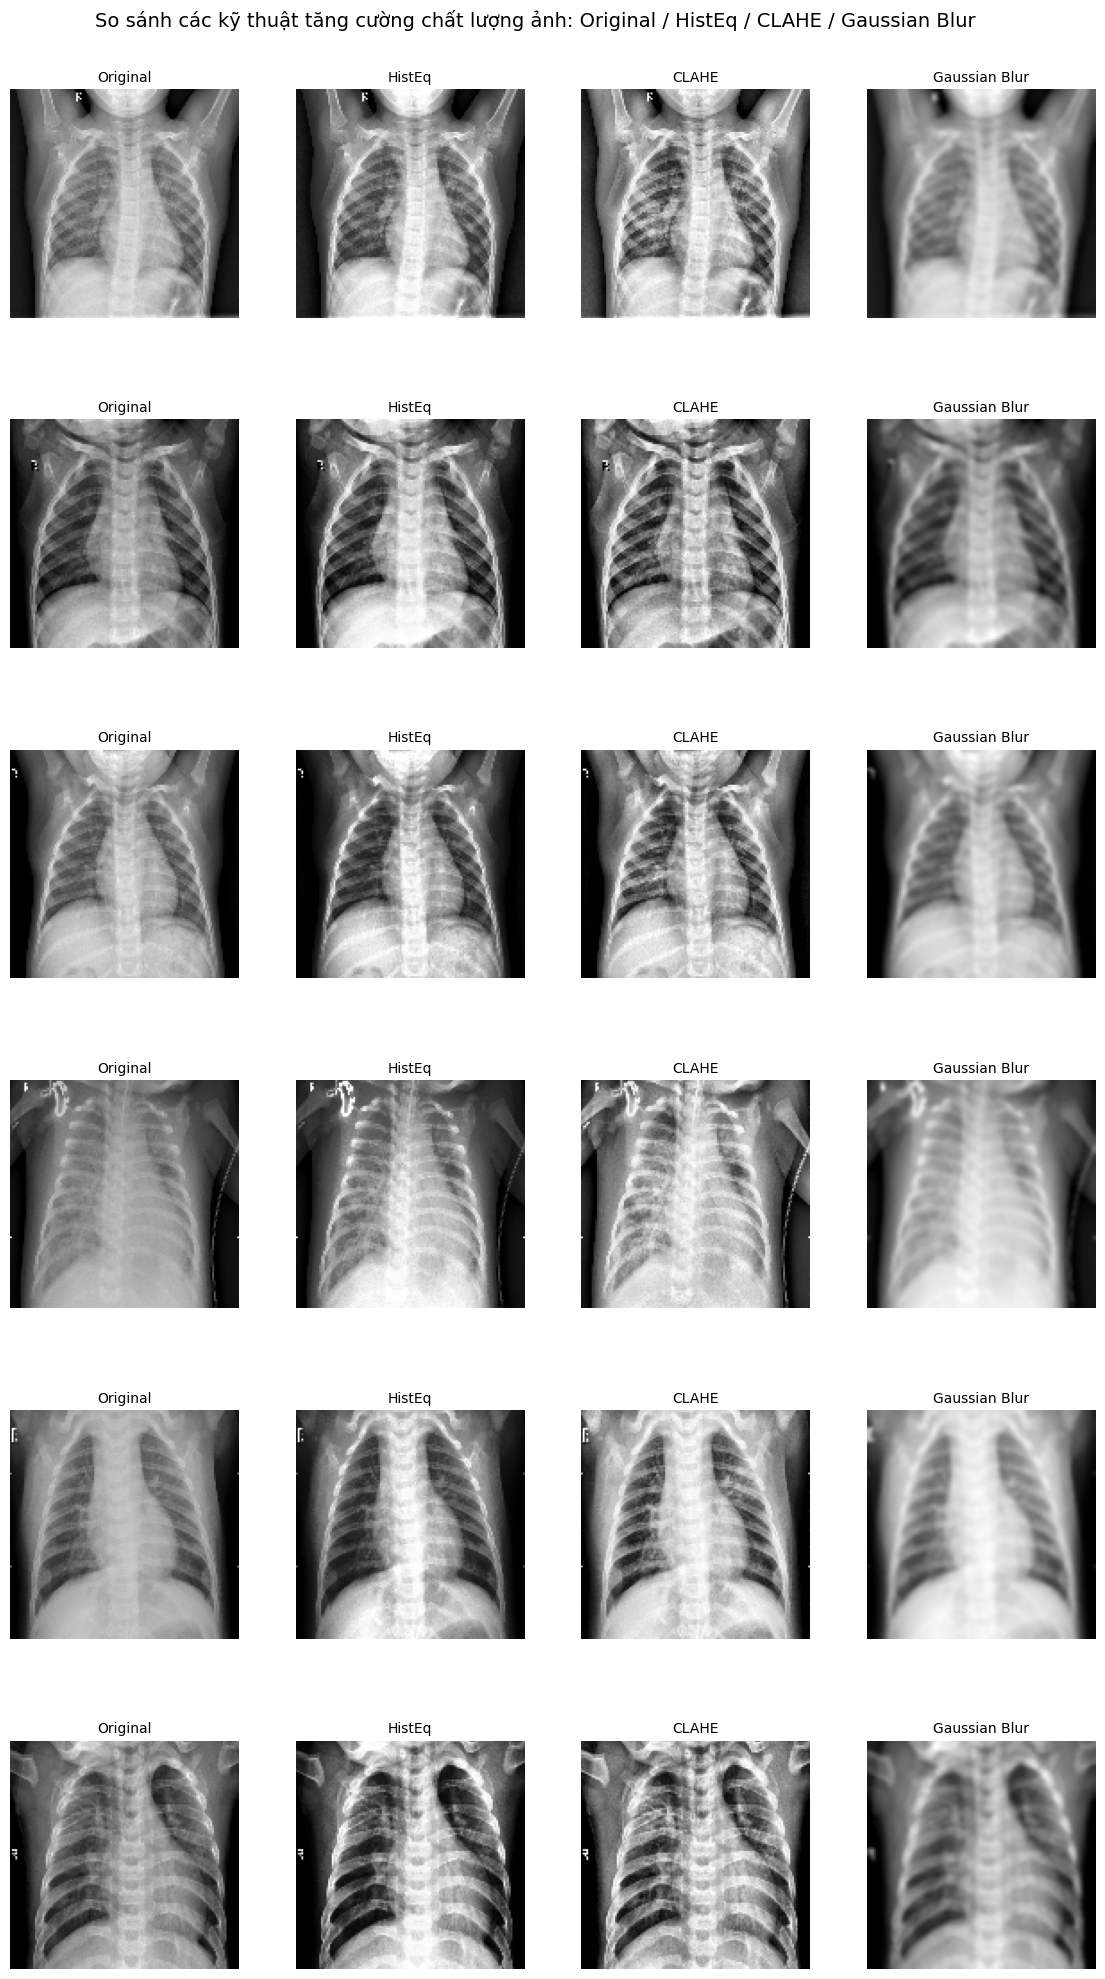

In [26]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hist_eq_imgs = [cv2.equalizeHist(img) for img in gray]
clahe_imgs = [clahe.apply(img) for img in gray]
blur_imgs = [cv2.GaussianBlur(img, (5,5), 0) for img in gray]

# Hiển thị: Original / HistEq / CLAHE / Blur
plt.figure(figsize=(14, 4 * len(gray)))

for i in range(len(gray)):
    # Original
    plt.subplot(len(gray), 4, 4*i + 1)
    plt.imshow(gray[i], cmap='gray')
    plt.title('Original', fontsize=10)
    plt.axis('off')

    # Histogram Equalization
    plt.subplot(len(gray), 4, 4*i + 2)
    plt.imshow(hist_eq_imgs[i], cmap='gray')
    plt.title('HistEq', fontsize=10)
    plt.axis('off')

    # CLAHE
    plt.subplot(len(gray), 4, 4*i + 3)
    plt.imshow(clahe_imgs[i], cmap='gray')
    plt.title('CLAHE', fontsize=10)
    plt.axis('off')

    # Gaussian Blur
    plt.subplot(len(gray), 4, 4*i + 4)
    plt.imshow(blur_imgs[i], cmap='gray')
    plt.title('Gaussian Blur', fontsize=10)
    plt.axis('off')

plt.subplots_adjust(top=0.90, hspace=0.35, wspace=0.25)
plt.suptitle('So sánh các kỹ thuật tăng cường chất lượng ảnh: Original / HistEq / CLAHE / Gaussian Blur',
             fontsize=14, y=0.93)
plt.show()

## 8. Phân tích định lượng và so sánh giữa hai lớp
Thống kê và biểu đồ histogram tổng hợp cho NORMAL vs PNEUMONIA.

In [27]:
def compute_stats(paths,nmax=300):
    vals=[]
    for p in paths[:nmax]:
        img=cv2.imread(p,cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img=cv2.resize(img,(128,128))
        vals.append(img.ravel())
    arr=np.concatenate(vals)
    return dict(mean=float(arr.mean()),std=float(arr.std()),min=int(arr.min()),max=int(arr.max()))

train_normal=sorted(glob(os.path.join(BASE_TRAIN_DIR,'NORMAL','*')))
train_pneu=sorted(glob(os.path.join(BASE_TRAIN_DIR,'PNEUMONIA','*')))
print('NORMAL stats:',compute_stats(train_normal))
print('PNEUMONIA stats:',compute_stats(train_pneu))

NORMAL stats: {'mean': 121.12038208007813, 'std': 62.9769834129535, 'min': 0, 'max': 255}
PNEUMONIA stats: {'mean': 124.04773152669271, 'std': 60.3754576510825, 'min': 0, 'max': 255}


## 9. Data Augmentation
Tăng đa dạng dữ liệu huấn luyện: lật, xoay, thay đổi sáng, thêm nhiễu.

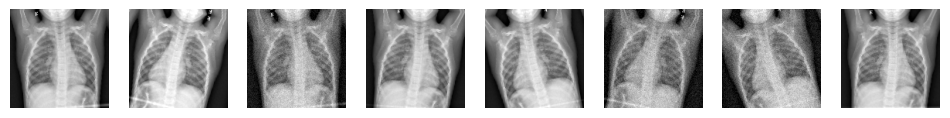

In [28]:
import math, random

def augment_image(img):
    out = img.copy()
    if random.random()<0.5: out=np.fliplr(out)
    angle=random.uniform(-15,15)
    M=cv2.getRotationMatrix2D((out.shape[1]/2,out.shape[0]/2),angle,1.0)
    out=cv2.warpAffine(out,M,(out.shape[1],out.shape[0]),borderMode=cv2.BORDER_REFLECT)
    factor=random.uniform(0.85,1.15)
    out=np.clip(out.astype(np.float32)*factor,0,255).astype(np.uint8)
    if random.random()<0.3:
        noise=np.random.normal(0,10,out.shape).astype(np.float32)
        out=np.clip(out.astype(np.float32)+noise,0,255).astype(np.uint8)
    return out

augmented=[augment_image(gray[0]) for _ in range(8)]
plt.figure(figsize=(12,4))
for i,a in enumerate(augmented):
    plt.subplot(1,8,i+1); plt.imshow(a,cmap='gray'); plt.axis('off')
plt.show()

## 10. Feature Extraction bằng PCA
Giảm chiều và trích xuất thành phần chính cho phân tích exploratory.

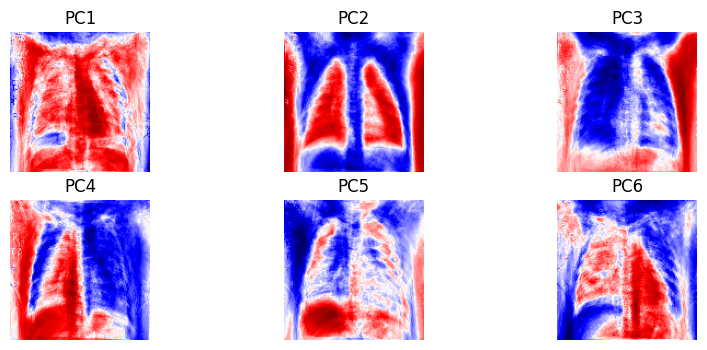

In [29]:
n_per_class=50
paths_sample=train_normal[:n_per_class]+train_pneu[:n_per_class]
X=[cv2.resize(cv2.imread(p,cv2.IMREAD_GRAYSCALE),(128,128)).ravel().astype(np.float32)/255.0 for p in paths_sample]
X=np.stack(X)
scaler=StandardScaler()
X_std=scaler.fit_transform(X)
pca=PCA(n_components=10)
X_pca=pca.fit_transform(X_std)

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(pca.components_[i].reshape(128,128),cmap='seismic')
    plt.title(f'PC{i+1}')
    plt.axis('off')
plt.show()

## 11. Kết luận phần Image Preprocessing

Trong phần **tiền xử lý ảnh (Image Preprocessing)**, toàn bộ quy trình đã được thực hiện:

1. **Loading & Resizing:** Chuẩn hóa kích thước ảnh về 128×128 giúp thống nhất đầu vào, giảm chi phí tính toán mà vẫn giữ được chi tiết quan trọng trong vùng phổi.  
2. **Grayscale Conversion:** Loại bỏ các kênh màu không cần thiết, tập trung vào cường độ sáng – yếu tố mang ý nghĩa chẩn đoán trong ảnh X-quang.  
3. **Normalization:** Chuẩn hóa giá trị pixel bằng Min–Max và Z-score giúp phân bố dữ liệu ổn định hơn, hỗ trợ quá trình huấn luyện mô hình hội tụ nhanh và giảm hiện tượng sai lệch do cường độ sáng khác nhau giữa ảnh.  
4. **Edge Detection:** Triển khai Sobel, Prewitt và Canny cho thấy các biên rõ nét của mô phổi và xương sườn, hỗ trợ tốt cho các bước trích xuất đặc trưng hoặc segmentation sau này.
5. **Enhancement Techniques:** Áp dụng Histogram Equalization, CLAHE và Gaussian Blur để tăng cường độ tương phản, giảm nhiễu, giúp làm nổi bật cấu trúc vùng phổi và tổn thương.  